### Define function to calculate precision@k and recall @k

In [1]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

### Import data

In [2]:
import send_status_mail as ssm
import joblib
from surprise import Dataset, Reader

df = joblib.load('../data/processed/preprocessed_data_movielens.pkl')
df.drop(columns=['title','genres','relevance','tag'], inplace=True)
# sort columns in required order
df = df[['userId', 'movieId', 'rating']]
# reset index, which was nonsense after import
df = df.reset_index().drop(columns=['index'])

# Load the data into Surprise format, columns have been sorted in required order (raw user id, raw item id, rating) beforehand
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df, reader)

### Define evaluation parameters

In [3]:
from surprise.model_selection import KFold

# instantiate kf with random_state for reproducibility
kf = KFold(n_splits=5, random_state=42)

# define measure for which GridSearch results will be retrieved
measure = 'mae'

# define evaluation parameters
n_rec = [3,5,10,20] # number of recommendations => top k
threshold = 3.5 # threshold for relevant recommendations (real rating >= threshold => relevant)

### Retrieve precision@k and recall@k for all models using k-fold prediction

In [4]:
from surprise import KNNBasic

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_knnBasic.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = KNNBasic(sim_options=gs_result.best_params[measure]['sim_options'], k= gs_result.best_params[measure]['k'], min_k=gs_result.best_params[measure]['min_k'])


# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_knnBasic_dict, recalls_knnBasic_dict = {}, {}
for k in n_rec:
    precisions_knnBasic_dict[k] = []
    recalls_knnBasic_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_knnBasic_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_knnBasic_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("knnBasic precision/recall@k")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [5]:
from surprise import KNNWithMeans

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_knnMeans.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = KNNWithMeans(sim_options=gs_result.best_params[measure]['sim_options'], k= gs_result.best_params[measure]['k'], min_k=gs_result.best_params[measure]['min_k'])


# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_knnMean_dict, recalls_knnMean_dict = {}, {}
for k in n_rec:
    precisions_knnMean_dict[k] = []
    recalls_knnMean_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_knnMean_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_knnMean_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("knnMeans precision/recall@k")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [6]:
from surprise import KNNBaseline

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_knnBaseline.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = KNNBaseline(sim_options=gs_result.best_params[measure]['sim_options'], k= gs_result.best_params[measure]['k'], min_k=gs_result.best_params[measure]['min_k'])


# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_knnBaseline_dict, recalls_knnBaseline_dict = {}, {}
for k in n_rec:
    precisions_knnBaseline_dict[k] = []
    recalls_knnBaseline_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_knnBaseline_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_knnBaseline_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("knnBaseline precision/recall@k")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [7]:
from surprise import KNNWithZScore

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_knnZScore.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = KNNWithZScore(sim_options=gs_result.best_params[measure]['sim_options'], k= gs_result.best_params[measure]['k'], min_k=gs_result.best_params[measure]['min_k'])


# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_knnZScore_dict, recalls_knnZScore_dict = {}, {}
for k in n_rec:
    precisions_knnZScore_dict[k] = []
    recalls_knnZScore_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_knnZScore_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_knnZScore_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("knnZScore precision/recall@k")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [36]:
from surprise import SVD

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_SVD.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = SVD(n_factors=gs_result.best_params[measure]['n_factors'],
           n_epochs=gs_result.best_params[measure]['n_epochs'],
           biased=gs_result.best_params[measure]['biased'],
           lr_all=gs_result.best_params[measure]['lr_all'],
           reg_all=gs_result.best_params[measure]['reg_all'],
           random_state=42)

# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_SVD_dict, recalls_SVD_dict = {}, {}
for k in n_rec:
    precisions_SVD_dict[k] = []
    recalls_SVD_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_SVD_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_SVD_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("SVD precision/recall@k")

In [48]:
from surprise import NMF

# import results from parameter tuning
gs_result = joblib.load('../models/surp_gridsearchcv_NMF.pkl')

# instantiate model with winner parameters from GridSearch according to desired measure, e.g. MAE
algo = NMF(n_factors=gs_result.best_params[measure]['n_factors'],
           n_epochs=gs_result.best_params[measure]['n_epochs'],
           biased=gs_result.best_params[measure]['biased'],
           reg_pu=gs_result.best_params[measure]['reg_pu'],
           reg_qi=gs_result.best_params[measure]['reg_qi'],
           random_state=42)

# initiate dicts holding lists of average precision/recall for different k (n_rec) respectively
# empty lists will be filled in the next loop, iteration over splits
precisions_NMF_dict, recalls_NMF_dict = {}, {}
for k in n_rec:
    precisions_NMF_dict[k] = []
    recalls_NMF_dict[k] = []

# iterate over all splits, for each split: train model, predict, retrieve precision/recall for top k recommendations
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    # iterate over all n_rec (number of recommendations): retrieve precision/recall for top k recommendations
    for k in n_rec:
        precisions, recalls = precision_recall_at_k(predictions, k, threshold)

        # Precision and recall can then be averaged over all users
        precisions_NMF_dict[k].append(sum(prec for prec in precisions.values()) / len(precisions))
        recalls_NMF_dict[k].append(sum(rec for rec in recalls.values()) / len(recalls))

# send completion message via email (server, sender, recepient according to .env)
ssm.sendstatus("NMF precision/recall@k")

In [53]:
# collect all dicts with precisions and recalls in one dict
surp_precision_at_k_recall_at_k = {}
surp_precision_at_k_recall_at_k['precisions_knnBasic_dict'] = precisions_knnBasic_dict
surp_precision_at_k_recall_at_k['recalls_knnBasic_dict'] = recalls_knnBasic_dict
surp_precision_at_k_recall_at_k['precisions_knnMean_dict'] = precisions_knnMean_dict
surp_precision_at_k_recall_at_k['recalls_knnMean_dict'] = recalls_knnMean_dict
surp_precision_at_k_recall_at_k['precisions_knnBaseline_dict'] = precisions_knnBaseline_dict
surp_precision_at_k_recall_at_k['recalls_knnBaseline_dict'] = recalls_knnBaseline_dict
surp_precision_at_k_recall_at_k['precisions_knnZScore_dict'] = precisions_knnZScore_dict
surp_precision_at_k_recall_at_k['recalls_knnZScore_dict'] = recalls_knnZScore_dict
surp_precision_at_k_recall_at_k['precisions_SVD_dict'] = precisions_SVD_dict
surp_precision_at_k_recall_at_k['recalls_SVD_dict'] = recalls_SVD_dict
surp_precision_at_k_recall_at_k['precisions_NMF_dict'] = precisions_NMF_dict
surp_precision_at_k_recall_at_k['recalls_NMF_dict'] = recalls_NMF_dict

# save dict to pkl
joblib.dump(surp_precision_at_k_recall_at_k, '../models/surp_precision_at_k_recall_at_k.json')


['../models/surp_precision_at_k_recall_at_k.json']

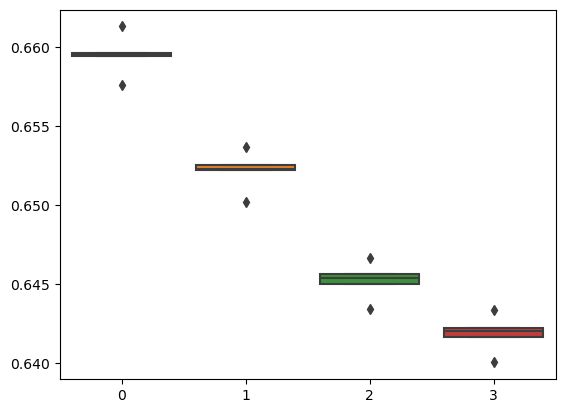

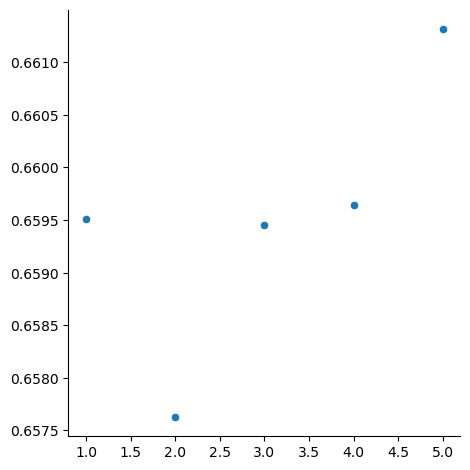

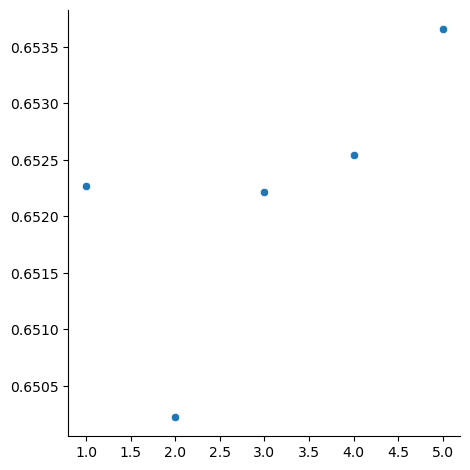

In [22]:
import seaborn as sns
import numpy as np
sns.boxplot([precisions_knnZScore_dict[3],precisions_knnZScore_dict[5],
             precisions_knnZScore_dict[10],precisions_knnZScore_dict[20]]);
sns.relplot(data=precisions_knnZScore_dict,x=[1,2,3,4,5],y=precisions_knnZScore_dict[3], label='k=3')
sns.relplot(data=precisions_knnZScore_dict,x=[1,2,3,4,5],y=precisions_knnZScore_dict[5])
#sns.relplot(data=precisions_knnZScore_dict,x=[3,5,10,20],y=(np.mean(precisions_knnZScore_dict[3])))

#### Testing reproducibility of splits

In [9]:
"""
kf = KFold(n_splits=5, random_state=42)
for trainset, testset in kf.split(data):
    print(trainset.global_mean)

# result #1
# 3.473827167636637
# 3.4742678511810365
# 3.4738866842197114
# 3.4744854068183715
# 3.4738730499427124

for trainset, testset in kf.split(data):
    print(trainset.global_mean)

# result #2
# 3.473827167636637
# 3.4742678511810365
# 3.4738866842197114
# 3.4744854068183715
# 3.4738730499427124

# => reproducibility is given
"""

'\nkf = KFold(n_splits=5, random_state=42)\nfor trainset, testset in kf.split(data):\n    print(trainset.global_mean)\n\n# result #1\n# 3.473827167636637\n# 3.4742678511810365\n# 3.4738866842197114\n# 3.4744854068183715\n# 3.4738730499427124\n\nfor trainset, testset in kf.split(data):\n    print(trainset.global_mean)\n\n# result #2\n# 3.473827167636637\n# 3.4742678511810365\n# 3.4738866842197114\n# 3.4744854068183715\n# 3.4738730499427124\n\n# => reproducibility is given\n'